<a href="https://colab.research.google.com/github/choiking10/ML-tutorial/blob/main/mnist_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Page

이 페이지는 google colab과 github 연동을 테스트하기 위한 페이지 입니다.

깃허브 정리는... 언젠가 하겠지 뭐... 

using device cuda
Epoch [0/20], Step [300/1200],d_loss: 0.00151632, g_loss: 22.73960114, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [600/1200],d_loss: 0.00078345, g_loss: 7.86932468, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [900/1200],d_loss: 0.00016443, g_loss: 9.16502285, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [1200/1200],d_loss: 0.02596659, g_loss: 6.12172413, D(x): 0.99, D(G(z)): 0.02
Epoch [1/20], Step [300/1200],d_loss: 0.00049776, g_loss: 9.37645721, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [600/1200],d_loss: 0.00029693, g_loss: 9.01456928, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [900/1200],d_loss: 0.01995353, g_loss: 5.70178127, D(x): 0.99, D(G(z)): 0.01
Epoch [1/20], Step [1200/1200],d_loss: 0.02681897, g_loss: 6.92146397, D(x): 0.98, D(G(z)): 0.00
Epoch [2/20], Step [300/1200],d_loss: 0.12193316, g_loss: 5.77449226, D(x): 0.94, D(G(z)): 0.03
Epoch [2/20], Step [600/1200],d_loss: 0.15265620, g_loss: 12.10941982, D(x): 0.90, D(G(z)): 0.00
Epoch [2/20], Step

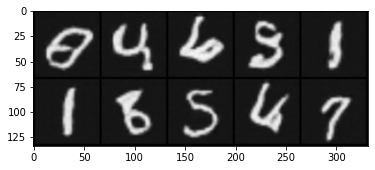

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt

def grid_image(tensor_images, size=10, nrow=5):
  tensor_images = ((tensor_images + 1) / 2 ).clamp(0, 1)
  return torchvision.utils.make_grid(tensor_images[:size], nrow=nrow)

def show_image(tensor_images, size=10, nrow=5):
  to_pil = transforms.ToPILImage()
  grid_img = grid_image(tensor_images)
  plt.imshow(to_pil(grid_img), interpolation="bicubic")

class Discriminator(nn.Module):
  def __init__(self, image_size=64):
    super(Discriminator, self).__init__()
    
    self.main = nn.Sequential(
        nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(image_size),
        nn.LeakyReLU(0.2),
        nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(image_size*2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(image_size*4),
        nn.LeakyReLU(0.2),
        nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(image_size*8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1, padding=0),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.main(x)

class Generator(nn.Module):
  def __init__(self, latent_size=100, image_size=64):
    super(Generator, self).__init__()
    # view B, C, H, W
    self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_size, image_size * 8, kernel_size=4, stride=1, padding=0),    # 4 * 4
        nn.BatchNorm2d(image_size * 8),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4,stride=2, padding=1), # 8 * 8
        nn.BatchNorm2d(image_size * 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4,stride=2, padding=1), # 16 * 16
        nn.BatchNorm2d(image_size * 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4,stride=2, padding=1),         # 32 * 32
        nn.BatchNorm2d(image_size * 1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(image_size, 1, kernel_size=4,stride=2, padding=1),         # 64 * 64
        nn.Tanh()
    )
  def forward(self, x):
    return self.main(x)

def binary_cross_entropy(out, target):
  return - torch.mean(target * torch.log(out + 1e-10) + (1-target) * torch.log(1-out+1e-10))

def main():
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"using device {device}")
  # Hyper-parameters

  latent_size = 100
  hidden_size = 256
  image_size = 64

  num_epochs = 20
  batch_size = 50
  sample_dir = 'samples'

  if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize(image_size)                              
  ])

  mnist = torchvision.datasets.MNIST(root='../../data/',
                                    train=True,
                                    transform=transform,
                                    download=True)

  data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                            batch_size=batch_size,
                                            shuffle=True)

  D = Discriminator(image_size).to(device)
  G = Generator(latent_size, image_size).to(device)

  d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
  g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

  total_step = len(data_loader)
  def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
  
  def rand_z():
    return torch.randn(batch_size, latent_size).to(device).view(-1, latent_size, 1, 1) 

  for epoch in range(num_epochs):
    fake_images = None
    for i, (images, _) in enumerate(data_loader):
      images = images.to(device)

      real_label = torch.ones(batch_size, 1).to(device)
      fake_label = torch.zeros(batch_size, 1).to(device)

      # ---- D ----
      z = rand_z()

      # real
      real_outputs = D(images)
      d_loss_real = binary_cross_entropy(real_outputs, real_label)
      real_score = real_outputs

      # fake
      fake_images = G(z)
      fake_outputs = D(fake_images)
      d_loss_fake = binary_cross_entropy(fake_outputs, fake_label)
      fake_score = fake_outputs
      
      # loss
      d_loss = d_loss_real + d_loss_fake
      
      # backprop
      reset_grad()
      d_loss.backward()
      d_optimizer.step()

      # ---- G ----
      z = rand_z()
      fake_images = G(z)
      outputs = D(fake_images)
      g_loss = binary_cross_entropy(outputs, real_label)
      
      reset_grad()
      g_loss.backward()
      g_optimizer.step()

      if (i + 1) % 300 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}],' + 
        f'd_loss: {d_loss:.8f}, g_loss: {g_loss:.8f}, ' + 
        f'D(x): {real_score.mean():.2f}, D(G(z)): {fake_score.mean():.2f}')
    if (epoch + 1) % 1 == 0:
      save_image(grid_image(fake_images.view(batch_size, 1, 64, 64)),
                  os.path.join(sample_dir, f'fake_images_{epoch+1:03d}.png'))
    
    if (epoch + 1) % 10 == 0:
      show_image(fake_images.view(batch_size, 1, 64, 64))
    
      

main()

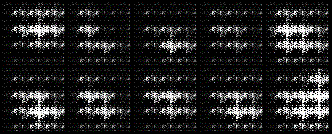

In [ ]:
import glob
from PIL import Image
# filepaths
fp_in = "samples/*.png"
fp_out = "result.gif"
stop_while = 5
# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
sorted_images = sorted(glob.glob(fp_in))

for i in range(5):
  sorted_images.append(sorted_images[-1])

img, *imgs = [Image.open(f) for f in (sorted_images)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

from IPython.display import Image, display
with open(fp_out,'rb') as f:
    display(Image(data=f.read(), format='png'))
